In [2]:
import pandas as pd
from glob import glob
import seaborn as sns
from bokeh.io import curdoc
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, RangeTool, NumeralTickFormatter, Range1d, LabelSet, HoverTool
from bokeh.themes import Theme
from bokeh.embed import components
from bokeh.transform import cumsum
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [32]:
# Styles for Bokeh Plots
THEME = Theme(json={
    'attrs': {
        'Figure': {
#             'sizing_mode': 'stretch_width',
#             'plot_height': 500,
            'background_fill_color': '#FFFFFF',
            'border_fill_color': '#FFFFFF',
            'outline_line_color': '#FFFFFF',
        },
        'Axis': {
            'major_label_text_font_size': '12pt',
            'minor_tick_line_color': "white",
            'axis_label_text_font_size': '14pt',
            'axis_label_text_font_style': 'bold',
            'axis_label_text_font_style': 'italic'
        },
        'Grid': {
            'grid_line_color': None
        },
        'Line': {
            'line_color': '#000000',
            'line_width': 2,
        },
        'Bar': {
            'fill_color': '#000000'
        },
        'Title': {
            'text_color': "#000000",
            'text_font_size': '16pt',
            'text_font_style': 'bold'
        }
    }
})
doc = curdoc()
doc.theme = THEME

# Colors for charts
PRIMARY_COLOR = '#000000'
SECONDARY_COLOR = '#000000'
GRAY = '#A9A9A9'
COLORS = ['#4101f5', '#21e68c', '#b22c99',
          '#8c1932', '#509bf5', '#fae62c', '#f59b22', '#f5729f', '#ff4935']
output_notebook()

Loading BokehJS ...

# Combine Datasets

In [4]:
df = pd.DataFrame()
for csv in glob('data/*.csv'):
    this_df = pd.read_csv(csv)
    df = df.append(this_df)

df.set_index('date', inplace=True)
df.to_csv('combined_data.csv')

In [5]:
combined_df = pd.read_csv('combined_data.csv')
combined_df.head()

,date,Unnamed: 0,end,start,tweet_count,published_at,source_id,source_name,author,content,...,url_image,id,coin,total_news_articles,reddit_board_members,reddit_board_threads,tweet_volume,twitter_followers,name,reddit_board_comments
0,NaN,0.0,2021-09-14T00:00:00.000Z,2021-09-13T00:00:00.000Z,31198.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2021-09-15T00:00:00.000Z,2021-09-14T00:00:00.000Z,42340.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2.0,2021-09-16T00:00:00.000Z,2021-09-15T00:00:00.000Z,42312.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.0,2021-09-17T00:00:00.000Z,2021-09-16T00:00:00.000Z,51686.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,4.0,2021-09-18T00:00:00.000Z,2021-09-17T00:00:00.000Z,49224.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Posts by Publication

In [6]:
by_publication = combined_df.groupby('source_name')[['url']].nunique().reset_index().sort_values(by='url').tail(20)
by_publication.columns = ['source', 'articles']

In [7]:
source = ColumnDataSource(by_publication)
p = figure(y_range = by_publication['source'], toolbar_location=None)
p.hbar(y='source', right='articles', source=source, color='#000000', height=.5)
p.x_range = Range1d(0, by_publication['articles'].max()*1.05)
show(p)

# By Author

In [8]:
by_author = combined_df.groupby('author')[['url']].nunique().reset_index().sort_values(by='url').tail(20)
by_author.columns = ['author', 'articles']
by_author['truncated'] = by_author['author'].apply(lambda x: x[0:45])

In [9]:
source = ColumnDataSource(by_author)
p = figure(y_range = by_author['truncated'], toolbar_location=None)
p.hbar(y='truncated', right='articles', source=source, color='#000000', height=.5)
p.x_range = Range1d(0, by_author['articles'].max()*1.05)
show(p)

# Word Counts

In [10]:
combined_df.head()

,date,Unnamed: 0,end,start,tweet_count,published_at,source_id,source_name,author,content,...,url_image,id,coin,total_news_articles,reddit_board_members,reddit_board_threads,tweet_volume,twitter_followers,name,reddit_board_comments
0,NaN,0.0,2021-09-14T00:00:00.000Z,2021-09-13T00:00:00.000Z,31198.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2021-09-15T00:00:00.000Z,2021-09-14T00:00:00.000Z,42340.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2.0,2021-09-16T00:00:00.000Z,2021-09-15T00:00:00.000Z,42312.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.0,2021-09-17T00:00:00.000Z,2021-09-16T00:00:00.000Z,51686.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,4.0,2021-09-18T00:00:00.000Z,2021-09-17T00:00:00.000Z,49224.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
no_nulls = combined_df.copy()
no_nulls = no_nulls.dropna(subset=['title', 'content'])
no_nulls['content'] = no_nulls['content'].apply(lambda x: x.replace('chars]', '')) #truncates and adds [+XXX chars]
no_nulls['text_concat'] = no_nulls['title'] + ' ' + no_nulls['content']
full_text = ', '.join(no_nulls['text_concat'].tolist())

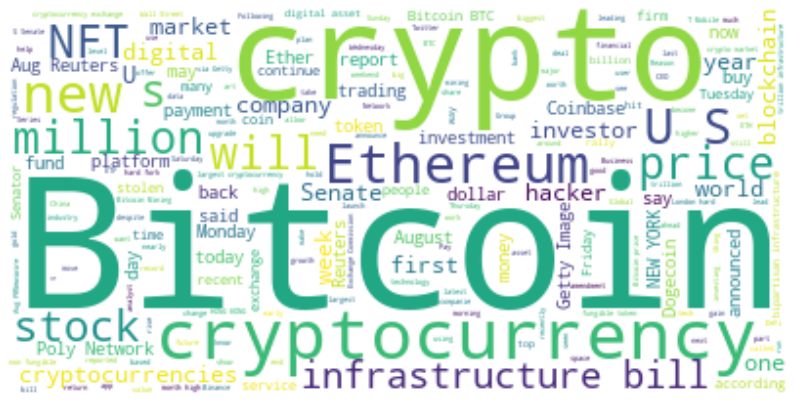

In [12]:
import matplotlib.pyplot as plt
text = full_text

# Create and generate a word cloud image:
fig, size = plt.subplots(figsize=(14, 8))
wordcloud = WordCloud(max_font_size=100, background_color='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Bigrams

In [13]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
stoplist = stopwords.words('english')
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(no_nulls['text_concat'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_

In [14]:
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [15]:
df_ngram.head(50)

,frequency,bigram/trigram
0,119,infrastructure bill
1,83,poly network
2,58,getty images
3,56,new york
4,53,bitcoin btc
5,48,600 million
6,44,bipartisan infrastructure
7,40,cryptocurrency exchange
8,36,bitcoin mining
9,35,largest cryptocurrency


# Tweet Volume

In [19]:
df = pd.read_csv('data/data_20210920.csv')
df.sort_values(by='tweet_volume', inplace=True)

In [22]:
df.head()

,id,coin,date,total_news_articles,reddit_board_members,reddit_board_threads,tweet_volume,twitter_followers,name,reddit_board_comments
0,148,AMP,2021-09-20 20:00:00,31,31436,25,184,29210,amp,626
1,150,ACH,2021-09-20 20:00:00,2,5936,6,352,40225,alchemy pay,51
6,175,FET,2021-09-20 20:00:00,1,5194,3,548,78942,fetch.ai,32
7,183,XMR,2021-09-20 20:00:00,2,235358,15,1832,440777,monero,235
10,213,SHIB,2021-09-20 20:00:00,1,223649,57,3416,908111,shiba,893


In [39]:
source = ColumnDataSource(df)
p = figure(
    y_range=df['coin'],
    plot_width=800,
    plot_height=500,
    title="Tweet Volume by Coin on September 21st, 2021"
)
p.hbar(y='coin', right='tweet_volume', color='#000000', height=.5, source=source)
p.x_range = Range1d(0, df['tweet_volume'].max()*1.05)
p.xaxis.formatter = NumeralTickFormatter(format='0,0a')
p.xaxis.axis_label = "Tweet Volume"
show(p)